# Long-Duration Energy Storage Example
---
In this example, we will show how to use and modify the long duration energy storage (LDES) parameters in the hybrid plant simulation. The LDES model is built inside of the battery module, so the parameters are very similar to the battery storage model. In this example we will model a vanadium redox flow battery (VRFB), but we have written the model in a general way so that many types of long-duration energy storage can be modeled reasonably easily.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
import numpy as np

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_generation_profile
)


/Users/jthomas2/Documents/programs/HOPP/examples/log/hybrid_systems_2025-04-17T14.54.28.881005.log


### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.



**NOTE**: For a load following objective function the `desired_schedule` must be set. You can also specify `curtailment_value_type` to either _"grid"_ or _"desired_schedule"_. If you select _"grid"_ the system will curtail energy at the interconnection limit but optimize to meet the `desired_schedule` load and if you select _"desired_schedule"_ it curtails energy above the `desired_schedule` and optimizes to meet the `desired_schedule` load.

In [2]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "hopp" / "simulation" / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "hopp" / "simulation"  / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "hopp" / "simulation" / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

setpoint_kw = float(10 * 1000)
DEFAULT_LOAD = setpoint_kw*np.ones((8760))/1000

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=DEFAULT_LOAD,
        curtailment_value_type="interconnect_kw",
        solar=True,
        wind=True,
        wave=False
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [ ]:
hopp_config = load_yaml("./inputs/11-load-following-long-duration-energy-storage.yaml")

# alert the model that a replacement schedule will be provided
hopp_config["technologies"]["battery"]["fin_model"]["battery_system"]["batt_replacement_option"] = 2
# set up the replacement schedule to replace the battery every 15 years at a cost of 50% of the initial capex
project_life_years = 25
refurb = [0]*project_life_years
battery_life_years = 15
for i in range(battery_life_years-1, project_life_years, battery_life_years):
    refurb[i] = 0.5

# assign replacement schedule to the input config
hopp_config["technologies"]["battery"]["fin_model"]["battery_system"]["batt_replacement_schedule_percent"] = refurb

# set battery om per kw including per kwh cost - om per kwh not included internally
battery_rating_kw = hopp_config["technologies"]["battery"]["system_capacity_kw"]
battery_rating_kwh = hopp_config["technologies"]["battery"]["system_capacity_kwh"]
batt_om_per_kwh = hopp_config["config"]["cost_info"]["battery_om_per_kwh"]
batt_om_per_kw = hopp_config["config"]["cost_info"]["battery_om_per_kw"]

# this is how to include om per kwh capacity costs
total_batt_om_per_kw = (battery_rating_kw*batt_om_per_kw + battery_rating_kwh*batt_om_per_kwh)/battery_rating_kw
hopp_config["config"]["cost_info"]["battery_om_per_kw"] = total_batt_om_per_kw

# remove om per kwh input because it is an invalid input to HOPP
hopp_config["config"]["cost_info"].pop("battery_om_per_kwh")

# set SiteInfo instance
hopp_config["site"] = site

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [4]:
hi = HoppInterface(hopp_config)


In [5]:

hi.system.battery.dispatch.charge_efficiency

# Note: HOPP LDES does not currently account for self discharge

# set round trip efficiency
hi.system.battery.dispatch.round_trip_efficiency = 80.0

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 25 years).

In [6]:
hi.simulate(project_life=project_life_years)

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [7]:
hybrid_plant = hi.system

print("Annual Energies (kWh):")
print(hybrid_plant.annual_energies)

print("\n Percentage of timesteps the load is met:")
print(hybrid_plant.grid.time_load_met)

print("\n Total Missed Load:")
print(sum(hybrid_plant.grid.missed_load), "kWh")

print("\n Percentage of the load that is missed:")
print(hybrid_plant.grid.missed_load_percentage)

Annual Energies (kWh):
{"pv": 11234203.208755787, "wind": 80310545.9331664, "battery": -1214.3240999997406, "hybrid": 91543534.81782195}

 Percentage of timesteps the load is met:
78.52739726027397

 Total Missed Load:
417274074.2328715 kWh

 Percentage of the load that is missed:
19.053610695564906


### Visualize Simulation Results (Optional)
Optionally, you can visualize the simulation results using plots. Several functions are provided for plotting battery output, generation profiles, and dispatch errors.

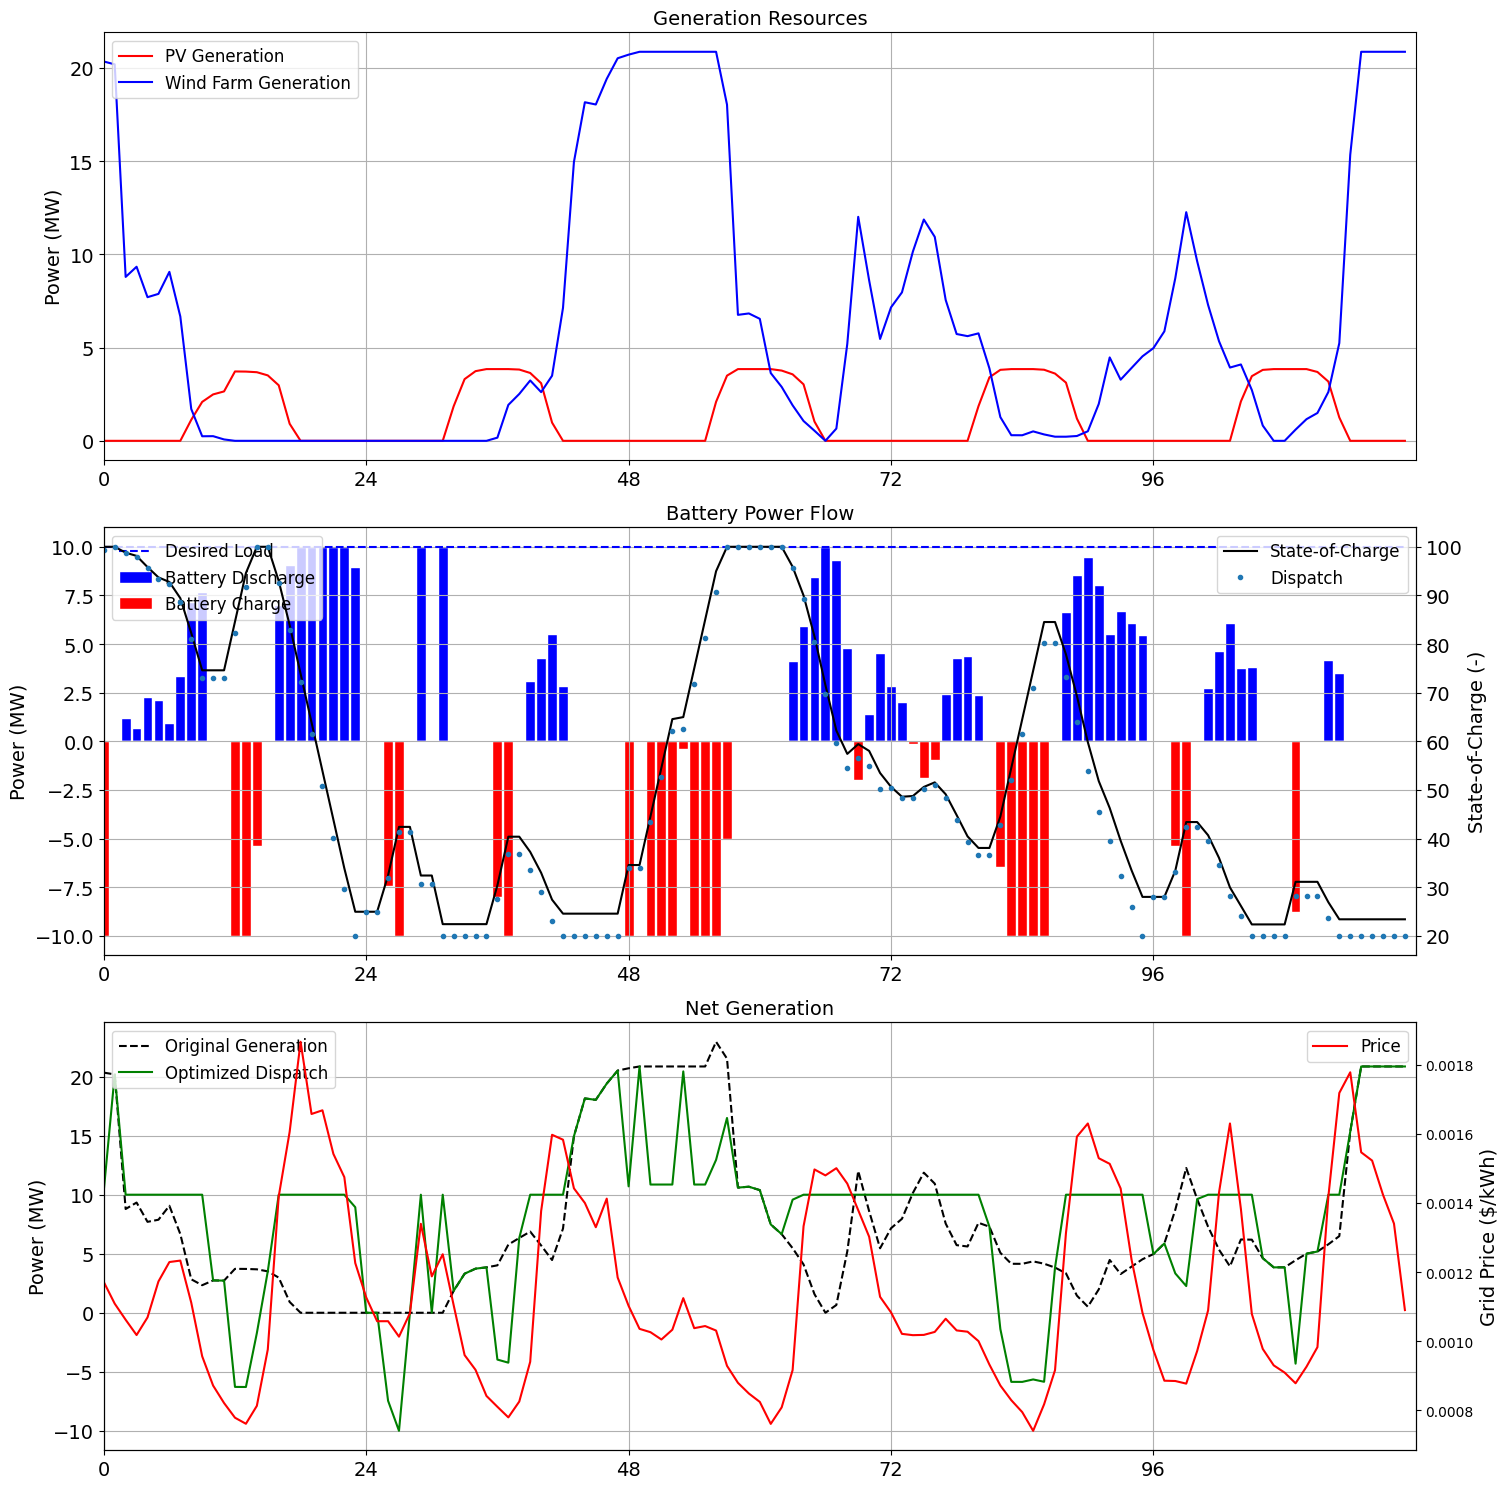

In [8]:
plot_generation_profile(hybrid_plant)